[https://qiita.com/tanaka_soichiro/items/56c02ad53bc0babe62ab](https://qiita.com/tanaka_soichiro/items/56c02ad53bc0babe62ab)

In [263]:
import numpy as np
import pandas as pd
from numpy import pi, exp, log
from numpy import dot, multiply, diag, power
from numpy.linalg import inv, eig, pinv
import matplotlib.pyplot as plt

In [264]:
# 実際のデータを用いてやってみる
df = pd.read_csv("data/dynamics/p.csv")
# 最初のデータ10個は死んでる
df = df[10:]

F = df["point1"].values

def normalize(x):
	"""1次元"""
	mu = np.mean(x)
	s = np.std(x)
	return (x - mu) / s

# 正規化
F = normalize(F)
N = len(F)
print("N:", N)
t_raw = np.linspace(0, 1, N)
dt = t_raw[2] - t_raw[1]

N: 67


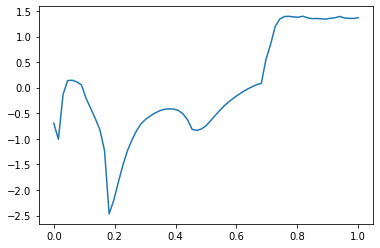

In [266]:
plt.plot(t_raw, F)

In [267]:
# 前処理(Hanakel行列化)
# N: 時系列の長さ, L: 任意のwinidowの大きさ, Nの半分以下にしないといけない
L = 30
K = N - L + 1
D = np.column_stack([F[i : i + L] for i in range(0, K)])
D.shape # (1windowに格納されている状態ベクトルの数, スナップショットの数)

(30, 38)

In [268]:
X = D[:, :-1]  # スナップショット群1
Y = D[:, 1:]  # スナップショット群2
t = np.arange(0, K - 1)  # スナップショット群に対するtime

In [269]:
# Y = AXとなるAを求める
# ここでsvdを施し、次元削減
U2, Sig2, Vh2 = np.linalg.svd(X)
print(U2.shape, Sig2.shape, Vh2.shape)

(30, 30) (30,) (37, 37)


In [270]:
# 寄与率を見ておく
sigma_sumsq = (Sig2 ** 2).sum()
cumlative_contrib = (Sig2 ** 2).cumsum() / sigma_sumsq * 100
cumlative_contrib

array([ 47.15810045,  81.15648214,  89.13907405,  94.64700678,
        96.67214613,  97.6043233 ,  98.28095603,  98.74365448,
        99.05919121,  99.29004999,  99.43804384,  99.58389384,
        99.67340511,  99.73315645,  99.78577749,  99.83571034,
        99.87835876,  99.91384877,  99.94054637,  99.95748976,
        99.96723076,  99.97283454,  99.97743671,  99.98160121,
        99.98569713,  99.9895633 ,  99.99316639,  99.99659652,
        99.99840607, 100.        ])

$$
A^{tilde} = U_r^* A U_r = U_r^* Y V_r \Sigma_r^{-1}
$$
ただし$U^*$は$U$の随伴行列（転置の複素共役とったやつ）

In [271]:

r = 10
U = U2[:,:r]
Sig = diag(Sig2)[:r,:r]  # 対角行列を作って、それのrランク
V = Vh2.conj().T[:,:r]  # conjは共役複素数

Atil = dot(dot(dot(U.conj().T, Y), V), inv(Sig))

In [272]:
mu, W = eig(Atil)  # 固有値と固有ベクトルを作成

In [273]:
freqs = np.angle(mu) / (2 * pi * dt)
for idx, freq in enumerate(freqs):
    print("mode" + str(idx) + " freq=" + str(freq))

mode0 freq=10.311263828322911
mode1 freq=-10.311263828322911
mode2 freq=6.315194311714431
mode3 freq=-6.315194311714431
mode4 freq=0.7977919107518748
mode5 freq=-0.7977919107518748
mode6 freq=2.5651296025332053
mode7 freq=-2.5651296025332053
mode8 freq=4.520520996598368
mode9 freq=-4.520520996598368


# 時間発展を考える

固有値$w_i$,固有ベクトル$\phi_i$ $(i=0, 1, r)$

$$
x(t) = \Sigma \phi_j \exp (w_j t) b_j = \Phi \exp(\Omega t) \bm{b}
$$

$$
\Omega = diag(w_j), w_j = \frac{\log(\lambda_)}{\Delta t}
$$

$$
\Phi = Y V_r \Sigma_r^{-1} W
$$

$$
b = \Phi^{\dagger} X
$$

In [274]:
Phi = dot(dot(dot(Y, V), inv(Sig)), W)
b = dot(pinv(Phi), X[:, 0])
Psi = np.zeros([r, len(t)], dtype="complex")
for idx, mu_elem in enumerate(mu):
    for _k in t:
        Psi[idx, _k] = exp(log(mu_elem) / dt * _k * dt) * b[idx]

In [275]:
# Compute DMD reconstruction for each mode
x_t_list = []
for idx, mu_elem in enumerate(mu):
    x_t = []
    for t_ in t:
        x_t.append(Phi[:, idx] * exp(log(mu_elem) / dt * t_ * dt) * b[idx])
    x_t = np.array(x_t).T
    x_t_list.append(x_t)
    # x_t_listには各モードの時間発展がかくのうされている

def X_to_TS(x_t):
    x0 = x_t[:, 0]
    x1 = x_t[-1, 1:]
    ts = np.concatenate([x0, x1], 0)
    print(ts.shape)
    return ts



# Convert Hankel matrix to time-series
x_t_recon = []
for x_t in x_t_list:
    x_t_recon.append(X_to_TS(x_t))
x_t_recon = np.array(x_t_recon)
F_recon = x_t_recon.sum(axis=0)

(66,)
(66,)
(66,)
(66,)
(66,)
(66,)
(66,)
(66,)
(66,)
(66,)


/home/ayumu/Documents/MAZIN/DynamicModeDecomposition/myvenv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


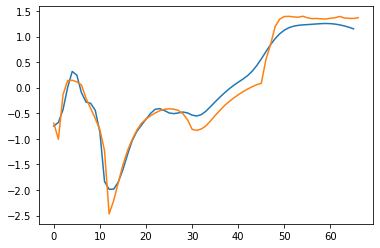

In [276]:
plt.plot(range(len(F_recon)), F_recon)
plt.plot(range(len(F)), F)

# 微分方程式を定義して時間発展させる
$$
\frac{dx}{dt} = \Sigma \phi_j w_j \exp(w_j t)b_j
$$

In [277]:
dF = F_recon[1:] - F_recon[:-1]
F_recon = np.zeros_like(F_recon)
F_recon[0] = F[0]

print(F_recon.shape, dF.shape)
for t in range(1, len(F_recon)):
	F_recon[t] = F_recon[t-1] + dF[t-1]
	

(66,) (65,)


/home/ayumu/Documents/MAZIN/DynamicModeDecomposition/myvenv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


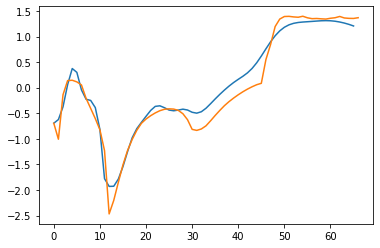

In [278]:
plt.plot(range(len(F_recon)), F_recon)
plt.plot(range(len(F)), F)

# EnKFをかます

In [279]:
import numpy as np
import pandas as pd
from tqdm import tqdm


def new_state(oldx, t):
    return oldx + dF[t]

N_PARTICLE = 50000
END_STEP = len(F_recon)
DIM = 1

x: np.ndarray = np.zeros((END_STEP, DIM))
z: np.ndarray = np.zeros((END_STEP, DIM))

px_pred: np.ndarray = np.zeros((END_STEP, N_PARTICLE, DIM))
px_ested: np.ndarray = np.zeros((END_STEP, N_PARTICLE, DIM))
pz_pred: np.ndarray = np.zeros((END_STEP, N_PARTICLE, DIM))
x_ested: np.ndarray = np.zeros((END_STEP, DIM))

kalman_gain: np.ndarray = np.zeros((END_STEP, DIM, DIM))

# init
x[0, :] = F[0]
x_ested[0, :] = F[0]
z[0] = F[0]
px_pred[0, :, :] = np.zeros((N_PARTICLE, DIM)) + np.random.normal(loc=F[0], scale=0.1)


for t in tqdm(range(END_STEP - 1)):
    # 真の値
    x[t + 1] = F[t + 1]
    # 観測
    z[t + 1] = np.zeros(DIM) + np.random.normal(loc=x[t+1], scale=0.1)

    for i in range(N_PARTICLE):
        px_pred[t + 1, i, :] = new_state(px_pred[t, i, :], t)
        pz_pred[t + 1, i, :] = px_pred[t + 1, i, :] + np.random.randn(DIM) / 10
    # 状態の誤差アンサンブル行列を出す
    _state_ave: np.ndarray = np.average(px_pred[t + 1], axis=0)
    state_ave = np.tile(_state_ave, (N_PARTICLE, 1))
    _state_diff_mat: np.ndarray = px_pred[t + 1, :, :] - state_ave  # 誤差アンサンブル行列
    state_diff_mat = _state_diff_mat.T

    # 出力の誤差アンサンブル行列を出す
    _obs_ave: np.ndarray = np.average(pz_pred[t + 1], axis=0)
    obs_ave = np.tile(_obs_ave, (N_PARTICLE, 1))
    _obs_diff_mat: np.ndarray = pz_pred[t + 1, :, :] - obs_ave
    obs_diff_mat = _obs_diff_mat.T

    # 共分散行列
    state_cov_mat = np.dot(state_diff_mat, _state_diff_mat) / (N_PARTICLE - 1)
    obs_cov_mat = np.dot(obs_diff_mat, _obs_diff_mat) / (N_PARTICLE - 1)

    # カルマンゲインを算出
    kalman_gain[t + 1, :, :] = np.dot(state_cov_mat, np.linalg.pinv(obs_cov_mat))

    # 各アンサンブルを更新
    for i in range(N_PARTICLE):
        px_ested[t + 1, i] = px_pred[t + 1, i] + np.dot(kalman_gain[t + 1], (z[t + 1] - pz_pred[t + 1, i]))

    # 推定
    x_ested[t + 1] = np.average(px_ested[t + 1], axis=0)
    
# df_true = pd.DataFrame(x, columns=["X", "Y", "Z"])
# df_ested = pd.DataFrame(x_ested, columns=["X", "Y", "Z"])
# df_obsed = pd.DataFrame(z, columns=["X", "Y", "Z"])

# # 誤差評価
# x_err = np.average(np.abs(x_ested - x), axis=0)
# err = {"N_PARTICLE": N_PARTICLE, "X_err": x_err[0], "Y_err": x_err[1], "Z_err": x_err[1]}
# print(err)


# df_true.to_csv("data/df_true.csv")
# df_ested.to_csv("data/df_ested.csv")
# df_obsed.to_csv("data/df_obsed.csv")

  0%|          | 0/65 [00:00<?, ?it/s]/tmp/ipykernel_143602/337005124.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  px_pred[t + 1, i, :] = new_state(px_pred[t, i, :], t)
100%|██████████| 65/65 [00:38<00:00,  1.69it/s]


/home/ayumu/Documents/MAZIN/DynamicModeDecomposition/myvenv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


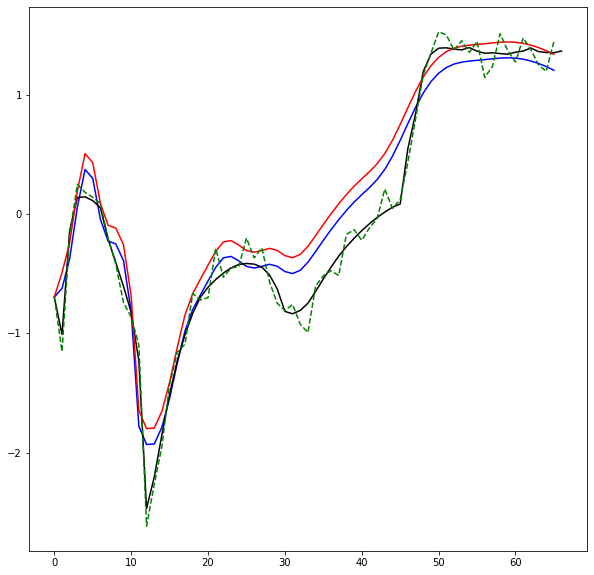

In [280]:
fig = plt.figure(figsize=(10, 10))
plt.plot(range(len(F_recon)), F_recon, color="blue", label="only model")
plt.plot(range(len(F)), F, color="black", label="true")
plt.plot(range(len(x_ested)), x_ested, color="red", label="smooth")
plt.plot(range(len(z)), z, color="green", linestyle="dashed", label="only observation")
